## Runtime Duration of UAT data
Analytics on Runtime data of the UAT reports.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# prep the environment
data_dir = Path.cwd() / "data"
data_file = data_dir / "uat_data.pkl"

%matplotlib inline


In [2]:
# load the UAT runtime data
if data_file.exists():
    uat_df = pd.read_pickle(data_file)
    print(f"Found {len(uat_df)} records.")
else:
    print(f"Processed data file missing ({data_file}), please run the Data Prep notebook first.")
    exit(-1)

# create time based DataFrame
time_df = uat_df.set_index('StartTime')


Found 621 records.


### Overview


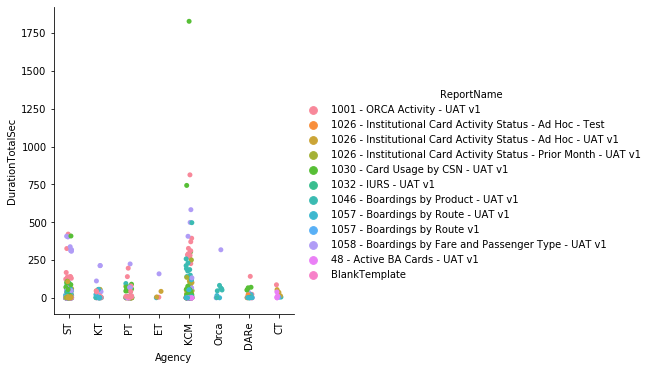

In [20]:
sns.catplot(x='Agency', y='DurationTotalSec', hue='ReportName', data=time_df)
plt.xticks(rotation=90)
plt.show()


### Runtime Split

What proportion of the total runtime is spent Retrieving, Rendering, and Processing the reports.


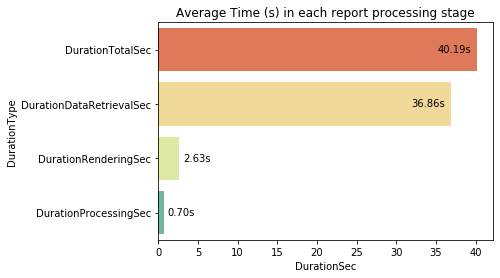

In [11]:
time_cols = ['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec']
time_duration_tidy_df = time_df.melt(['User', 'ResultStatus', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=time_cols)
fig, ax = plt.subplots()    
sns.barplot(x='DurationSec', y='DurationType', data=time_duration_df, palette='Spectral', ci=None)
for i, tcol in enumerate(time_cols):
    val = time_duration_tidy_df[time_duration_tidy_df['DurationType'] == tcol]['DurationSec'].mean()
    if val > 5:
        offset = val - 5
    else:
        offset = val + .5
    ax.text(offset, i + 0.05, f"{val:.2f}s")
plt.title('Average Time (s) in each report processing stage')
plt.show()


### Interactivity

What proportion of the total runtime is spent on Interactive vs Scheduled report.
This will likely only change significantly once we have regular users.


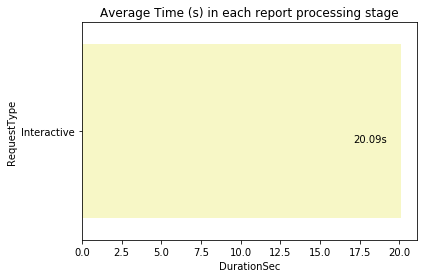

In [51]:
time_cols = ['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec']
time_duration_df = time_df.melt(['RequestType', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=time_cols)
# fig, ax = plt.subplots()    
bplot = sns.barplot(x='DurationSec', y='RequestType', data=time_duration_df, palette='Spectral', ci=None)
for i, tcol in enumerate(time_duration_df['RequestType'].unique()):
    val = time_duration_df[time_duration_df['RequestType'] == tcol]['DurationSec'].mean()
    if val > 5:
        offset = val - 3
    else:
        offset = val + .5
    # ax.text(offset, i + 0.05, f"{val:.2f}s")
    bplot.text(offset, i + 0.05, f"{val:.2f}s")
plt.title('Average Time (s) in each report processing stage')
# bplot.text(0.5, 1, 'Average Time (s) in each report processing stage')
plt.show()

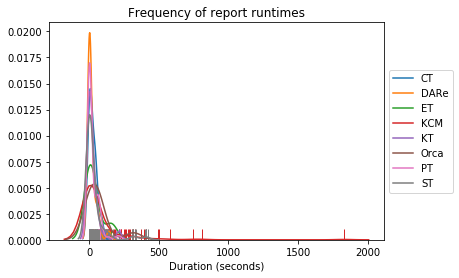

In [53]:
for agency, df in time_df.groupby('Agency'):
    sns.distplot(df['DurationTotalSec'], rug=True, hist=False, label=agency)
plt.xlabel("Duration (seconds)")
plt.title("Frequency of report runtimes")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


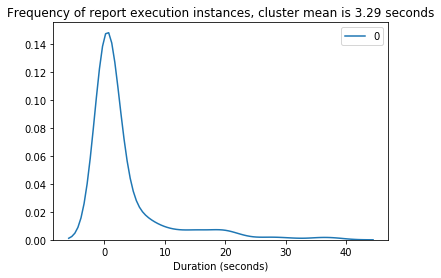

'There are 459 reports execution instances with the mean of 3.29 seconds'

'1001 - ORCA Activity - UAT v1'

'1046 - Boardings by Product - UAT v1'

'1057 - Boardings by Route - UAT v1'

'1026 - Institutional Card Activity Status - Prior Month - UAT v1'

'1026 - Institutional Card Activity Status - Ad Hoc - UAT v1'

'1032 - IURS - UAT v1'

'1058 - Boardings by Fare and Passenger Type - UAT v1'

'48 - Active BA Cards - UAT v1'

'1030 - Card Usage by CSN - UAT v1'

'BlankTemplate'

'1057 - Boardings by Route v1'

'1026 - Institutional Card Activity Status - Ad Hoc - Test'

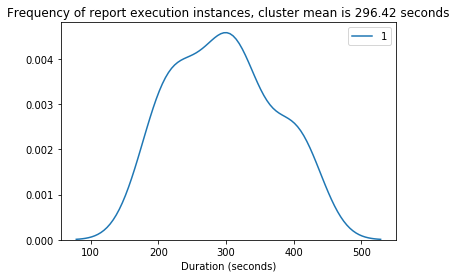

'There are 31 reports execution instances with the mean of 296.42 seconds'

'1058 - Boardings by Fare and Passenger Type - UAT v1'

'1001 - ORCA Activity - UAT v1'

'1030 - Card Usage by CSN - UAT v1'

'1046 - Boardings by Product - UAT v1'

'1026 - Institutional Card Activity Status - Prior Month - UAT v1'

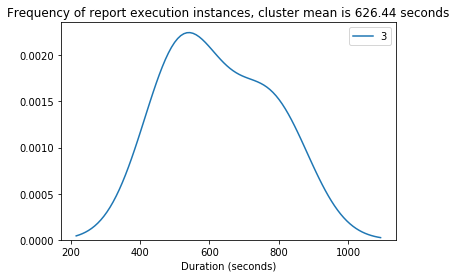

'There are 5 reports execution instances with the mean of 626.44 seconds'

'1058 - Boardings by Fare and Passenger Type - UAT v1'

'1030 - Card Usage by CSN - UAT v1'

'1001 - ORCA Activity - UAT v1'

'1046 - Boardings by Product - UAT v1'

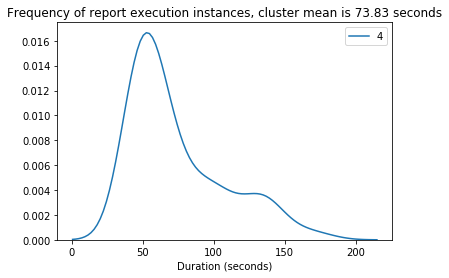

'There are 125 reports execution instances with the mean of 73.83 seconds'

'1058 - Boardings by Fare and Passenger Type - UAT v1'

'1026 - Institutional Card Activity Status - Ad Hoc - UAT v1'

'1030 - Card Usage by CSN - UAT v1'

'1046 - Boardings by Product - UAT v1'

'1026 - Institutional Card Activity Status - Prior Month - UAT v1'

'1001 - ORCA Activity - UAT v1'

'1057 - Boardings by Route - UAT v1'

'1032 - IURS - UAT v1'

In [91]:
from sklearn.cluster import KMeans
import numpy as np
num_clusters = 5
kmeans = KMeans(n_clusters = num_clusters)
kmeans.fit(np.array(uat_df['DurationTotalSec']).reshape(-1,1))
uat_df['RunClass'] = kmeans.labels_
# uat_df['RunClassCentroid'] = kmeans.cluster_centers_
# uat_df['RunClass'].replace({0:'Fast', 1:'Slow'}, inplace=True)
for runclass, df in uat_df.groupby('RunClass'):
    if len(df) < 2:
        continue
#     print(f"RunClass {runclass} has {len(df)} entries")
#     sns.distplot(df['DurationTotalSec'], rug=True, hist=False, label=runclass)
    sns.kdeplot(df['DurationTotalSec'], label=runclass)
    plt.xlabel("Duration (seconds)")
    df_mean = kmeans.cluster_centers_[runclass][0]
    plt.title(f"Frequency of report execution instances, cluster mean is {df_mean:.2f} seconds")
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    display(f"There are {len(df)} reports execution instances with the mean of {df_mean:.2f} seconds")
    for report in df['ReportName'].unique():
        display(report)
